# <center>Task Quality Measurement</center>

## Table of Contents<a class="anchor" id="top"></a>
* [Intro](#intro)
* [Data Cleaning](#data_cleaning)
* [Univariate Analysis](#univariate)
* [Bivariate Analysis](#bivariate)
* [Multivariate Analysis](#multivariate)

## Intro<a class="anchor" id="intro"></a>
For this project, I'll analyze task data from one of our teams for insights on task quality measurement. Ideas for this analysis:
* How does total resolution time (TRT) vary across members of the team? See if we can set a benchmark for this metric.
* Determine whether satisfaction score is correlated with task volume. If so, use this to suggest when additional head count is needed to maintain high task quality.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats

%matplotlib inline

In [3]:
tasks = pd.read_csv('task_quality_measurement_external.csv')

In [4]:
tasks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5643 entries, 0 to 5642
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ticket_id             5643 non-null   int64  
 1   created_time          5643 non-null   int64  
 2   creation_date         5643 non-null   object 
 3   first_assigned_time   5393 non-null   float64
 4   first_comment_time    5289 non-null   float64
 5   completed_time        5166 non-null   float64
 6   ticket_filer_id       5636 non-null   float64
 7   filer_business_title  5634 non-null   object 
 8   task_owner_id         5642 non-null   float64
 9   input_source          5643 non-null   object 
 10  tag_ids               5642 non-null   object 
 11  product_l1            5548 non-null   object 
 12  closure_reason        3683 non-null   object 
 13  difficulty            3683 non-null   float64
 14  job_family_name       391 non-null    object 
 15  feedback_ignore      

In [5]:
tasks['difficulty'].describe()

count    3683.000000
mean        2.006516
std         0.958940
min        -1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         5.000000
Name: difficulty, dtype: float64

[Back to top](#top)

## Data Cleaning<a class="anchor" id="data_cleaning"></a>
* Check tasks with null first_assigned_time
* Check tasks with null filer_business_title
* Why do some tasks have a negative difficulty score?

### Null first_assigned_time

I did some spot checks. These tasks indeed did not have someone from our team assigned, and they were addressed by other teams. We can remove these from the data set.

In [6]:
tasks.dropna(subset=['first_assigned_time'], inplace=True)

### Null filer_business_title

Checked these manually and found that these were actually not tasks for our team. We can drop these.

In [7]:
tasks.drop([1716, 4259], inplace=True)

### Negative difficulty score

In [8]:
tasks['difficulty'].value_counts()

 2.0    1660
 3.0     985
 1.0     631
 0.0     276
 4.0     101
 5.0      18
-1.0      11
Name: difficulty, dtype: int64

Checked the query that produced the data set. A difficulty of -1 is for tasks where there is no difficulty info. Will change to null in the data set.

In [9]:
tasks['difficulty'].replace(-1.0, np.nan, inplace=True)

[Back to top](#top)

## Univariate Analysis<a class="anchor" id="univariate"></a>

### Distribution of TRT

In [10]:
tasks.loc[:, 'trt_days'] = (tasks['completed_time'] - tasks['first_assigned_time'])/(60*60*24)

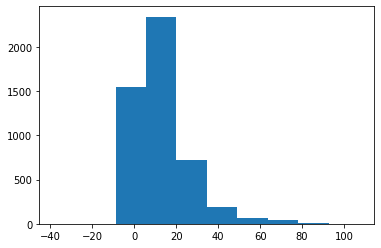

In [11]:
plt.hist(data=tasks, x='trt_days');

Some tasks have a negative TRT, which doesn't look right. Manual checks showed that this was due to the task being closed before someone from our team was assigned. This behavior will make our analysis of the tasks invalid, so I'll remove these from the data set.

In [12]:
tasks = tasks[(tasks.trt_days.isna()) | (tasks.trt_days >= 0)]

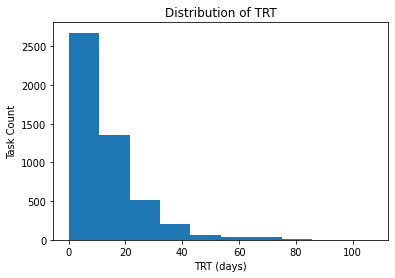

In [13]:
plt.hist(data=tasks, x='trt_days')
plt.title('Distribution of TRT')
plt.xlabel('TRT (days)')
plt.ylabel('Task Count');

Most tasks have a TRT under 3 weeks.

### Distribution of TRT by task_owner_id

In [14]:
s_trt = tasks[tasks['trt_days'].isna() == False].groupby(by='task_owner_id').mean()['trt_days'].sort_values(ascending=False)

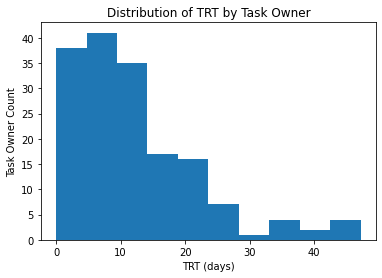

In [15]:
s_trt.hist(grid=False)
plt.title('Distribution of TRT by Task Owner')
plt.xlabel('TRT (days)')
plt.ylabel('Task Owner Count');

As with the distribution of TRT overall, most of the task owners have an average TRT of under 3 weeks, and the data is skewed to the right.

### Task volume breakdown by closure reason

In [16]:
tasks['closure_reason'].value_counts()

Issue Solved                  2616
Abandoned, No Response         640
Unsupported                    247
Escalated                      131
Duplicate                       19
None                            11
Closure Reason                  11
Solved - Product Confusion       4
Name: closure_reason, dtype: int64

Will relabel closure_reason of 'Solved - Product Confusion' to 'Issue Solved'. This will simplify the categories.

In [17]:
tasks.loc[tasks['closure_reason'] == 'Solved - Product Confusion', 'closure_reason'] = 'Issue Solved'

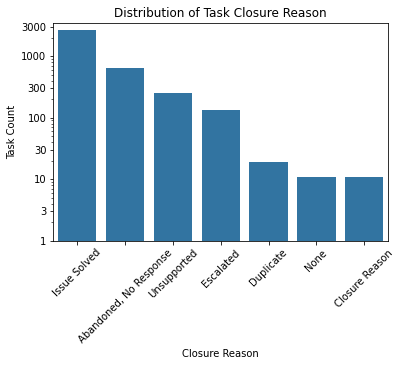

In [18]:
base_color = sb.color_palette()[0]

sb.countplot(data=tasks, x='closure_reason', color=base_color,
             order=['Issue Solved', 'Abandoned, No Response', 'Unsupported', 'Escalated', 'Duplicate', 'None', 'Closure Reason']).set_yscale('log')
plt.xticks(rotation=45)
plt.yticks(ticks=[1,3,10,30,100,300,1000,3000], labels=[1,3,10,30,100,300,1000,3000])
plt.title("Distribution of Task Closure Reason")
plt.xlabel("Closure Reason")
plt.ylabel("Task Count");


### Task volume breakdown by difficulty

In [19]:
tasks['difficulty'].value_counts()

2.0    1657
3.0     985
1.0     631
0.0     276
4.0     101
5.0      18
Name: difficulty, dtype: int64

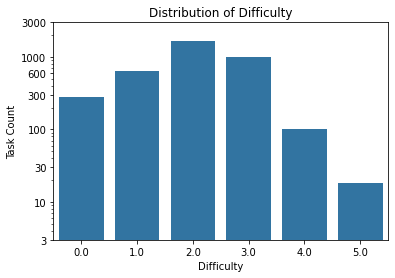

In [20]:
sb.countplot(data=tasks, x='difficulty', color=base_color).set_yscale('log')
plt.yticks(ticks=[3,10,30,100,300,600,1000,3000], labels=[3,10,30,100,300,600,1000,3000])
plt.title("Distribution of Difficulty")
plt.xlabel("Difficulty")
plt.ylabel("Task Count");

### Task volume breakdown by satisfaction_score

In [21]:
tasks_sat = tasks[tasks.feedback_ignore == 'NO'].copy()

In [22]:
tasks_sat['satisfaction_score'].value_counts()

5.0    340
4.0     11
1.0      6
2.0      5
3.0      5
Name: satisfaction_score, dtype: int64

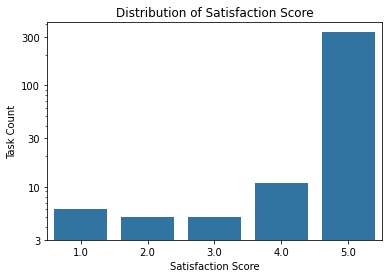

In [23]:
sb.countplot(data=tasks_sat, x='satisfaction_score', color=base_color).set_yscale('log')
plt.yticks(ticks=[3,10,30,100,300], labels=[3,10,30,100,300])
plt.title("Distribution of Satisfaction Score")
plt.xlabel("Satisfaction Score")
plt.ylabel("Task Count");

### Distribution of satisfaction_score by task_owner_id

In [24]:
s_sat = tasks_sat.groupby(by='task_owner_id').mean()['satisfaction_score'].sort_values(ascending=False)

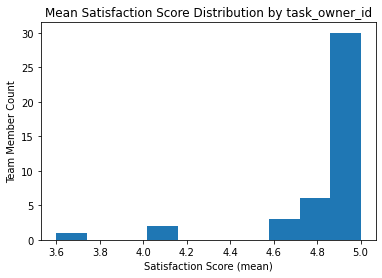

In [25]:
s_sat.hist(grid=False)
plt.title('Mean Satisfaction Score Distribution by task_owner_id')
plt.xlabel('Satisfaction Score (mean)')
plt.ylabel('Team Member Count');

### Check on helpful_text values

In [26]:
tasks['helpful_text'].value_counts()

Very Helpful          200
 Very Helpful         148
Very Unhelpful          9
 Somewhat Helpful       9
Somewhat Unhelpful      7
In The Middle           6
Somewhat Helpful        5
 In The Middle          4
 Very Unhelpful         3
Name: helpful_text, dtype: int64

Let's remove the leading whitespace for some of these values

In [27]:
tasks['helpful_text'] = tasks['helpful_text'].str.strip()

In [28]:
tasks['helpful_text'].value_counts()

Very Helpful          348
Somewhat Helpful       14
Very Unhelpful         12
In The Middle          10
Somewhat Unhelpful      7
Name: helpful_text, dtype: int64

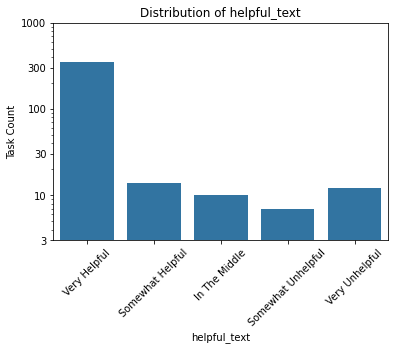

In [29]:
sb.countplot(data=tasks, x='helpful_text', color=base_color,
    order=['Very Helpful', 'Somewhat Helpful', 'In The Middle', 'Somewhat Unhelpful', 'Very Unhelpful']).set_yscale('log')
plt.xticks(rotation=45)
plt.yticks(ticks=[3,10,30,100,300,1000], labels=[3,10,30,100,300,1000])
plt.title("Distribution of helpful_text")
plt.xlabel("helpful_text")
plt.ylabel("Task Count");

### Insights - Univariate Exploration
* Most tasks have a TRT under 3 weeks. Distribution of TRT has a long right skew. We could use this as a benchmark for how long tasks should take to be completed.

[Back to top](#top)

## Bivariate Analysis<a class="anchor" id="bivariate"></a>
### TRT - distribution of values by task_owner_id

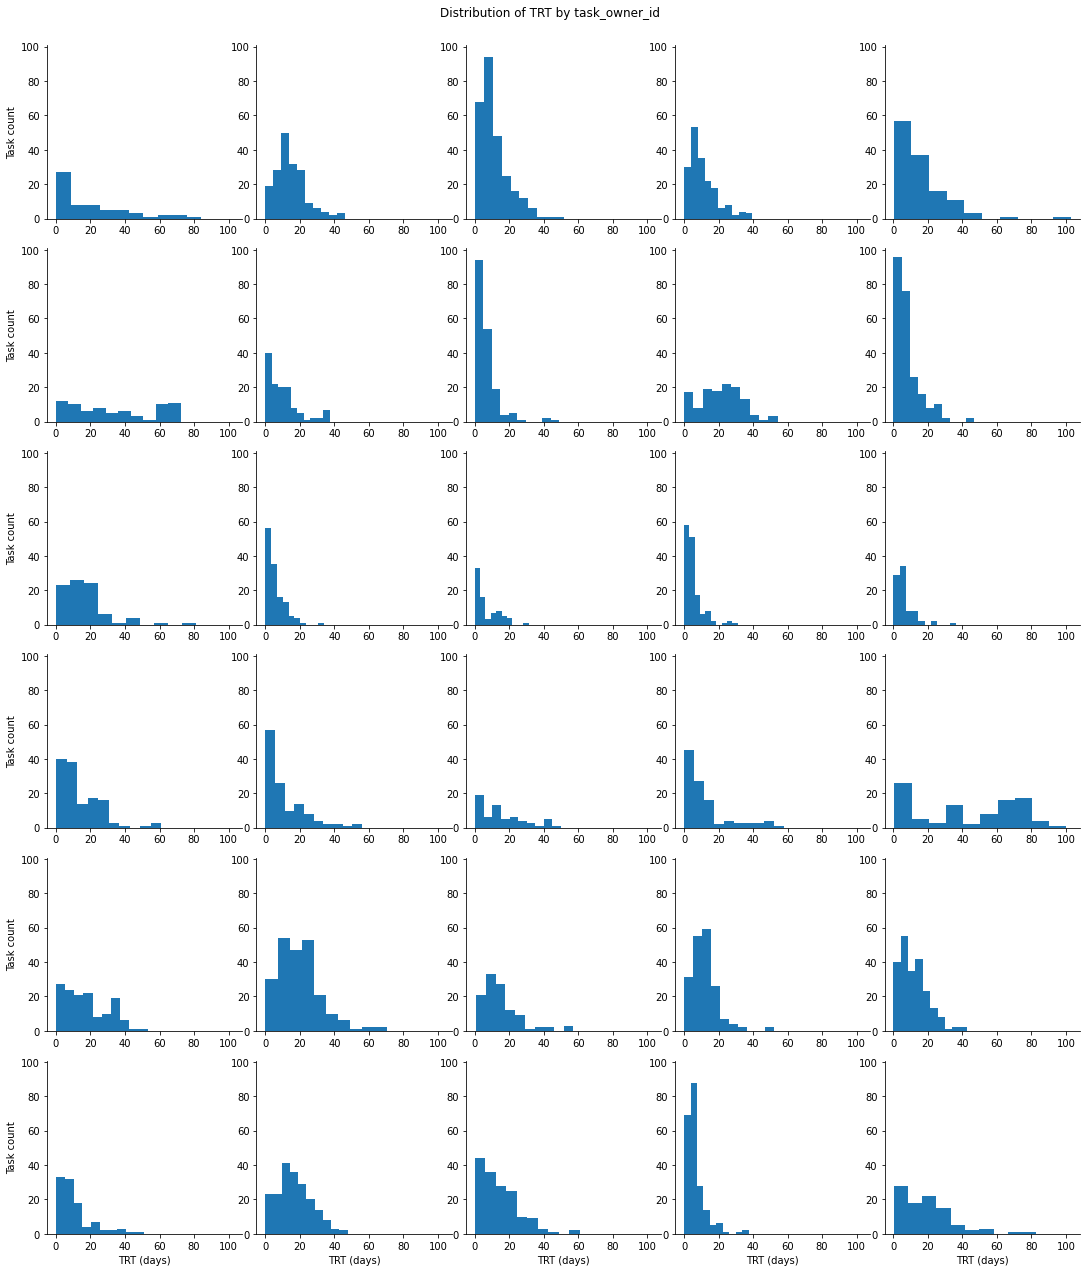

In [30]:
# Identify top task_owner_id's by task count
task_owner_filter = tasks['task_owner_id'].value_counts().head(30)

tasks_trt = tasks[(tasks.trt_days.isna() == False) & (tasks.task_owner_id.isin(task_owner_filter.index))].copy()
g = sb.FacetGrid(data=tasks_trt, col='task_owner_id', col_wrap=5)
g.map(plt.hist, 'trt_days')
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle("Distribution of TRT by task_owner_id")
g.set_axis_labels("TRT (days)", "Task count")

for ax in g.axes.flatten():
    ax.tick_params(labelleft=True, labelbottom=True)
    ax.set_title("");

Right skew for distribution of TRT by task_owner_id is common. That being said, a number of people have TRT of 3 weeks or less for most of their closed tasks.

### Is TRT correlated with Satisfaction Score?

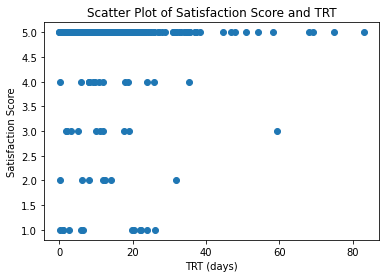

In [31]:
plt.scatter(data=tasks, x='trt_days', y='satisfaction_score')
plt.title("Scatter Plot of Satisfaction Score and TRT")
plt.xlabel("TRT (days)")
plt.ylabel("Satisfaction Score");

Not seeing much correlation between TRT and CSAT.

### Is RSAT correlated with CSAT?

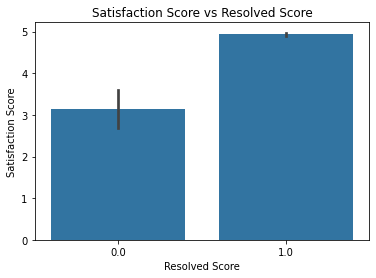

In [32]:
sb.barplot(data=tasks, x='resolved_score', y='satisfaction_score', color=base_color)
plt.title("Satisfaction Score vs Resolved Score")
plt.xlabel("Resolved Score")
plt.ylabel("Satisfaction Score");

Resolved tasks have higher satisfaction score, which makes sense

### Relationship between satisfaction score and task count for each task_owner_id

In [33]:
s_task_count = tasks.groupby(by=['task_owner_id']).count()['ticket_id'].sort_values(ascending=False)

In [34]:
df_sat_task_count = pd.merge(s_sat, s_task_count, on='task_owner_id')
df_sat_task_count.rename(columns={'ticket_id':'task_count'}, inplace=True)

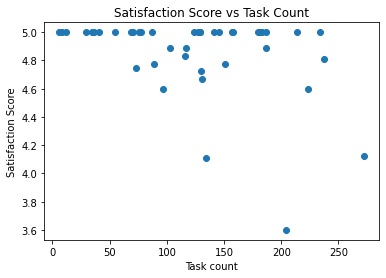

In [35]:
plt.scatter(data=df_sat_task_count, x='task_count', y='satisfaction_score')
plt.title('Satisfaction Score vs Task Count')
plt.xlabel('Task count')
plt.ylabel('Satisfaction Score');

In [36]:
stats.pearsonr(df_sat_task_count['task_count'], df_sat_task_count['satisfaction_score'])

(-0.3756193343482434, 0.01423277836385456)

Task count has a low negative correlation with CSAT (correlation coefficient of -0.38).

### Insights - Bivariate Exploration
* Right skew for distributions of TRT by task_owner_id is common. A majority of the breakdowns by task_owner_id showed most tasks having TRT of 3 weeks or less. The 3 week benchmark looks reasonable for the majority of the team.
* Not seeing much correlation between TRT and CSAT. Some of the issues we receive are complicated and can take a while to close. This makes it difficult to justify setting a hard goal around TRT. However if people have a TRT that is much higher or lower than the 3 week benchmark, it would be worth investigating the reasons behind that.
* Resolved tasks have higher satisfaction score, which makes sense
* Task count has a low negative correlation with satisfaction score (correlation coefficient of -0.38). As a next step, the team leads suggested breaking this down by job title.

### Follow-ups - Bivariate Exploration
* Satisfaction score vs task volume - breakdown by job_family_name

[Back to top](#top)

## Multivariate Analysis<a class="anchor" id="multivariate"></a>

### Satisfaction score vs task volume - breakdown by job family name

In [37]:
tasks_sat.loc[tasks_sat.job_family_name == "Technology Consultant", 'job_family_name'] = "Senior Consultant"
tasks_sat.loc[tasks_sat.job_family_name == "CW-Contingent Worker", 'job_family_name'] = "Junior Consultant"

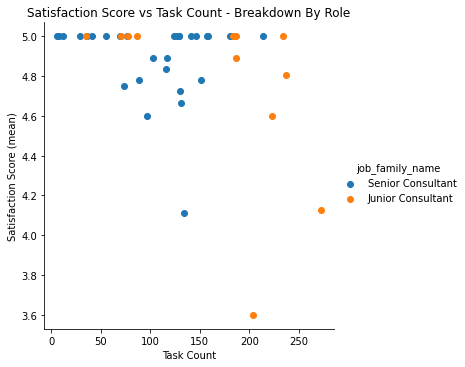

In [38]:
s_sat_job_family = tasks_sat.groupby(by=['task_owner_id', 'job_family_name']).mean()['satisfaction_score'].sort_values(ascending=False)
df_sat_job_family = s_sat_job_family.to_frame().reset_index()
df_sat_job_family_task_count = df_sat_job_family.merge(s_task_count, on='task_owner_id')
df_sat_job_family_task_count.rename(columns={'ticket_id':'task_count'}, inplace=True)
df_sat_job_family_task_count

g = sb.FacetGrid(data=df_sat_job_family_task_count, hue='job_family_name', height=5)
g.map(plt.scatter, 'task_count', 'satisfaction_score')
g.add_legend()
plt.title('Satisfaction Score vs Task Count - Breakdown By Role')
plt.xlabel('Task Count')
plt.ylabel('Satisfaction Score (mean)');

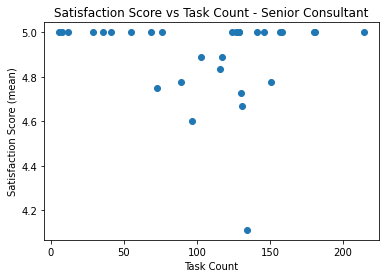

In [39]:
df_sat_task_count_sr = df_sat_job_family_task_count[df_sat_job_family_task_count.job_family_name == 'Senior Consultant']
plt.scatter(data=df_sat_task_count_sr, x='task_count', y='satisfaction_score')
plt.title('Satisfaction Score vs Task Count - Senior Consultant')
plt.xlabel('Task Count')
plt.ylabel('Satisfaction Score (mean)');

In [40]:
stats.pearsonr(df_sat_task_count_sr['task_count'], df_sat_task_count_sr['satisfaction_score'])

(-0.12825707776457368, 0.4993956534751485)

Task count for senior consultants has a very low negative correlation with satisfaction score (correlation coefficient of -0.13)

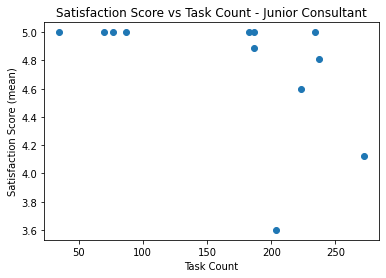

In [41]:
df_sat_task_count_jr = df_sat_job_family_task_count[df_sat_job_family_task_count.job_family_name == 'Junior Consultant']
plt.scatter(data=df_sat_task_count_jr, x='task_count', y='satisfaction_score')
plt.title('Satisfaction Score vs Task Count - Junior Consultant')
plt.xlabel('Task Count')
plt.ylabel('Satisfaction Score (mean)');

In [42]:
stats.pearsonr(df_sat_task_count_jr['task_count'], df_sat_task_count_jr['satisfaction_score'])

(-0.4779813432962028, 0.11602048761180385)

Task count for junior consultants has a moderate negative correlation with satisfaction score (correlation coefficient of -0.48). The team leads suggested removing the outlier with the low satisfaction score of around 3.6, as this was considered an anomaly. Let's see how the correlation coefficient looks after this data point is removed.

In [43]:
df_sat_task_count_jr_no_ol = df_sat_task_count_jr.drop([41])

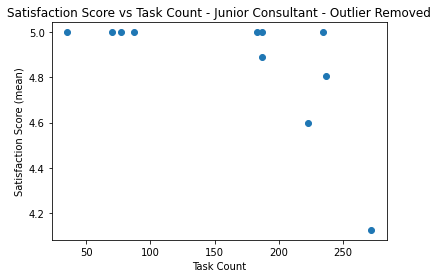

In [44]:
plt.scatter(data=df_sat_task_count_jr_no_ol, x='task_count', y='satisfaction_score')
plt.title('Satisfaction Score vs Task Count - Junior Consultant - Outlier Removed')
plt.xlabel('Task Count')
plt.ylabel('Satisfaction Score (mean)');

In [45]:
stats.pearsonr(df_sat_task_count_jr_no_ol['task_count'], df_sat_task_count_jr_no_ol['satisfaction_score'])

(-0.6149166682738681, 0.044071093883722386)

After removing the outlier, task count for junior consultants showed a high negative correlation with satisfaction score (correlation coefficient of -0.61).

### Insights - Multivariate Exploration
* For junior consultants, there is a moderate negative correlation between satisfaction score and task count (correlation coefficient of -0.48). This correlation was higher after removing the outlier (correlation coefficient changed to -0.61). Recommend adding head count when junior consultants have more than 90 tasks per month. At this volume, satisfaction score started to drop below the target.

[Back to top](#top)